In [1]:
import torch
import torch.nn as nn
import torch.utils.data
import torchvision
from functools import partial
from torch import optim
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms

tensorboard --logdir=runs

In [2]:
writer = SummaryWriter()
writer.add_scalar('example', 3)

In [4]:
import random
value = 10
writer.add_scalar('test_loop', value, 0)
for i in range(1, 10000):
    value += random.random() - 0.5
    writer.add_scalar('test_loop', value, i)

In [5]:
# resnet visualisation - необходимо передать саму модель и тензор для трассировки графа
from torchvision import models

model = models.resnet18(False)
writer.add_graph(model, torch.rand([1, 3, 224, 224]))

#### Использование хуков для получения информации о модели

In [8]:
def print_hook(self, module, inp, outp):
    print('Shape input is {0}'.format(inp.shape))

# применяем хук при прямом проходе, сохраняем ссылку на объект хука
model(torch.rand([1, 3, 224, 224]))
hook_ref = model.fc.register_forward_hook(print_hook)
hook_ref.remove() # убираем хук
model(torch.rand([1, 3, 224, 224]))

tensor([[-4.0559e-01, -5.4750e-01,  1.7231e-01, -1.1816e-01,  9.6418e-01,
         -7.6533e-01,  4.5932e-02,  3.3473e-01,  3.0338e-02,  1.9006e-01,
         -7.4424e-01, -6.2147e-01,  1.0637e-01, -4.4457e-01, -2.2575e-01,
         -8.9592e-02, -4.3492e-01, -3.7914e-02, -5.7275e-01, -8.6920e-01,
          2.2201e-01,  5.2262e-01, -2.1334e-01,  3.5553e-01, -3.9271e-02,
         -1.5388e-02, -6.8094e-01,  2.8797e-01, -3.5601e-01, -3.2038e-01,
         -4.2639e-02, -1.5817e-01, -9.7811e-01, -8.0342e-01, -1.9465e-01,
          6.0866e-01, -2.8846e-01, -3.9827e-02, -3.9155e-01, -1.8197e-02,
         -7.6056e-01, -3.4742e-01,  3.2052e-01, -3.5247e-01, -8.7206e-01,
          1.0139e+00, -6.0379e-01, -9.9967e-01, -3.9774e-02, -3.8887e-01,
          2.5508e-01, -3.8452e-01, -3.2984e-02, -5.8198e-01, -3.2430e-01,
         -8.3038e-02, -1.7649e-01,  6.8163e-01,  7.3631e-01, -4.8466e-01,
         -3.6978e-01, -8.6214e-01,  4.6410e-01,  3.9925e-01,  2.8768e-01,
          1.9155e-01, -3.9436e-02, -1.

#### Хуки для tensorboard для получения статистики

In [9]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))]
)
trainset = datasets.MNIST("mnist_train", train=True, download=True, transform=transform)
train_data_loader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
model = torchvision.models.resnet50(False)

Extracting mnist_train/MNIST/raw/train-images-idx3-ubyte.gz to mnist_train/MNIST/raw


Extracting mnist_train/MNIST/raw/train-labels-idx1-ubyte.gz to mnist_train/MNIST/raw


Extracting mnist_train/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist_train/MNIST/raw


Extracting mnist_train/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist_train/MNIST/raw
Processing...
Done!





/opt/conda/conda-bld/pytorch_1591914855613/work/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [10]:
model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
images, labels = next(iter(train_data_loader))

In [11]:
grid = torchvision.utils.make_grid(images)
writer.add_image("images", grid, 0)
writer.add_graph(model, images)

In [12]:
def send_stats(i, module, input, output):
    writer.add_scalar(f"layer {i}-mean", output.data.mean())
    writer.add_scalar(f"layer {i}-stddev", output.data.std())


for i, m in enumerate(model.children()):
    m.register_forward_hook(partial(send_stats, i))

In [13]:
# Now train the model and watch output in Tensorboard

optimizer = optim.Adam(model.parameters(), lr=2e-2)
criterion = nn.CrossEntropyLoss()


def train(
    model, optimizer, loss_fn, train_loader, val_loader, epochs=20, device="cuda:0"
):
    model.to(device)
    for epoch in range(epochs):
        print(f"epoch {epoch+1}")
        model.train()
        for batch in train_loader:
            optimizer.zero_grad()
            ww, target = batch
            ww = ww.to(device)
            target = target.to(device)
            output = model(ww)
            loss = loss_fn(output, target)
            loss.backward()
            optimizer.step()

        model.eval()
        num_correct = 0
        num_examples = 0
        for batch in val_loader:
            ww, target = batch
            ww = ww.to(device)
            target = target.to(device)
            output = model(ww)
            correct = torch.eq(torch.max(output, dim=1)[1], target).view(-1)
            num_correct += torch.sum(correct).item()
            num_examples += correct.shape[0]
        print("Epoch {}, accuracy = {:.2f}".format(epoch+1, num_correct / num_examples))


train(model, optimizer, criterion, train_data_loader, train_data_loader, epochs=5)

epoch 1
Epoch 1, accuracy = 0.88
epoch 2
Epoch 2, accuracy = 0.98
epoch 3
Epoch 3, accuracy = 0.95
epoch 4
Epoch 4, accuracy = 0.97
epoch 5
Epoch 5, accuracy = 0.98


## Карты активации класса

Метод визуализации активации сети после активации входящего тензора. Чтобы сгенерировать карту для CNN, захватывается активация последнего слоя свертки непосредственно перед линейным слоем. Делается это на хуках pytorch

In [4]:
%matplotlib inline

from PIL import Image
from matplotlib.pyplot import imshow
from torch.autograd import Variable
from torch import topk
import numpy as np
import skimage.transform

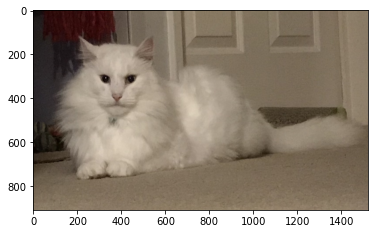

In [5]:
image = Image.open("img/casper2.jpg")
imshow(image)

In [6]:
# заворачиваем хук в класс
class SaveFeatures():
    features=None
    def __init__(self, m): 
        self.hook = m.register_forward_hook(self.hook_fn)
        
    def hook_fn(self, module, input, output): 
        self.features = ((output.cpu()).data).numpy()
        
    def remove(self): 
        self.hook.remove()

In [7]:
#нормализуем изображение для imagenet

# Imagenet mean/std

normalize = transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
)

# Preprocessing - scale to 224x224 for model, convert to tensor, 
# and normalize to -1..1 with mean/std for ImageNet

preprocess = transforms.Compose([
   transforms.Resize((224, 224)),
   transforms.ToTensor(),
   normalize
])

display_transform = transforms.Compose([
   transforms.Resize((224, 224))])

In [8]:
tensor = preprocess(image)

In [9]:
prediction_var = Variable((tensor.unsqueeze(0)).cuda(), requires_grad=True)

In [11]:
from torchvision import models

In [12]:
model = models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /home/konstantin/.cache/torch/checkpoints/resnet18-5c106cde.pth


In [13]:
model.cuda()
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [14]:
final_layer = model._modules.get('layer4')

In [15]:
activated_features = SaveFeatures(final_layer)

In [17]:
from torch.nn import functional as F

In [18]:
# получим предсказание для изображения
prediction = model(prediction_var)
pred_probabilities = F.softmax(prediction).data.squeeze()

/home/konstantin/anaconda3/envs/pytorch-gpu/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until


In [19]:
activated_features.remove()

In [20]:
# посмотрим на прогноз с помощью topk
topk(pred_probabilities,1)

torch.return_types.topk(
values=tensor([0.7832], device='cuda:0'),
indices=tensor([283], device='cuda:0'))

Теперь нужно из тензора, который содержит активации последнего слоя, получить изображение, удалив минимумы из тензора и масштабируя по максимуму

In [21]:
def getCAM(feature_conv, weight_fc, class_idx):
    _, nc, h, w = feature_conv.shape
    cam = weight_fc[class_idx].dot(feature_conv.reshape((nc, h*w)))
    cam = cam.reshape(h, w)
    cam = cam - np.min(cam)
    cam_img = cam / np.max(cam)
    return [cam_img]

In [22]:
weight_softmax_params = list(model._modules.get('fc').parameters())
weight_softmax = np.squeeze(weight_softmax_params[0].cpu().data.numpy())

In [23]:
weight_softmax_params

[Parameter containing:
 tensor([[-0.0185, -0.0705, -0.0518,  ..., -0.0390,  0.1735, -0.0410],
         [-0.0818, -0.0944,  0.0174,  ...,  0.2028, -0.0248,  0.0372],
         [-0.0332, -0.0566, -0.0242,  ..., -0.0344, -0.0227,  0.0197],
         ...,
         [-0.0103,  0.0033, -0.0359,  ..., -0.0279, -0.0115,  0.0128],
         [-0.0359, -0.0353, -0.0296,  ..., -0.0330, -0.0110, -0.0513],
         [ 0.0021, -0.0248, -0.0829,  ...,  0.0417, -0.0500,  0.0663]],
        device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([-2.6341e-03,  3.0005e-03,  6.5581e-04, -2.6909e-02,  6.3637e-03,
          1.3260e-02, -1.1178e-02,  2.0639e-02, -3.6373e-03, -1.2325e-02,
         -1.2629e-02, -7.2057e-03, -1.9321e-02, -2.4960e-02, -1.1885e-02,
         -8.3259e-03, -9.5745e-03, -1.6658e-02,  9.1804e-03, -1.5354e-02,
          7.1358e-03,  3.0737e-02,  1.3239e-02, -7.7528e-03,  4.7448e-03,
          1.1175e-02,  1.5949e-02, -1.6712e-02, -1.0130e-03, -3.7167e-03,
          6.5269e-03, -

In [24]:
class_idx = topk(pred_probabilities, 1)[1].int()

In [25]:
overlay = getCAM(activated_features.features, weight_softmax, class_idx)


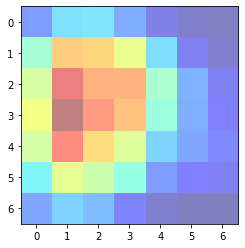

In [26]:
imshow(overlay[0], alpha=0.5, cmap='jet')

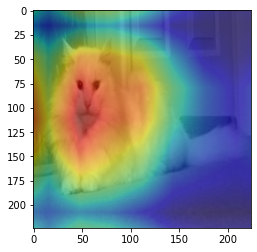

In [27]:
imshow(display_transform(image))
imshow(skimage.transform.resize(overlay[0], tensor.shape[1:3]), alpha=0.5, cmap='jet');

Посмотрим на что еще смотрела модель

In [28]:
class_idx = topk(pred_probabilities, 2)[1].int()

In [29]:
class_idx

tensor([283, 332], device='cuda:0', dtype=torch.int32)

In [30]:
overlay = getCAM(activated_features.features, weight_softmax, 332 )

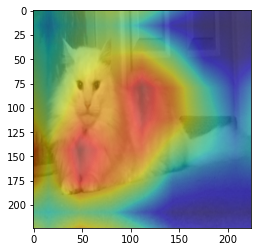

In [31]:
imshow(display_transform(image))
imshow(skimage.transform.resize(overlay[0], tensor.shape[1:3]), alpha=0.5, cmap='jet');

## Флеймграфы

[py-spy](https://github.com/KonstantinKlepikov/py-spy)

py-spy record -o profile.svg --pid 12345

OR

py-spy record -o profile.svg -- python myprogram.py

посмотреть пример: py-spy record -o output/profile.svg -- pytorch_learning/flametest.py

#### Пример - решение задачи медленного преобразования 

код запускать из файла в папке pytorch_learning через:

py-spy record -o profile.svg -- python bad_random.py

In [ ]:
device = 'cuda:0'
model = models.resnet18(pretrained=True)
train_data_path = "pytorch_learning/train/"
model.to(device)

In [32]:
class BadRandom(object):
    def __call__(self, img):
        img_np = np.array(img)
        random = np.random.random_sample(img_np.shape)
        out_np = img_np + random
        out = Image.fromarray(out_np.astype('uint8'), 'RGB')
        return out

    def __repr__(self):
        str = f"{self.__class__.__name__}"
        return str

In [ ]:
image_transforms = torchvision.transforms.Compose(
    [transforms.Resize((224, 224)),
     BadRandom(), 
     transforms.ToTensor()]
)

In [ ]:
train_data = torchvision.datasets.ImageFolder(root=train_data_path,
                                              transform=image_transforms)
batch_size=32
train_data_loader = torch.utils.data.DataLoader(train_data, 
                                                batch_size=batch_size)

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=2e-2)
criterion = nn.CrossEntropyLoss()

In [ ]:
def train(model, optimizer, loss_fn,  train_loader, val_loader, epochs=20, device='cuda:0'):
    model.to(device)
    for epoch in range(epochs):
        print(f"epoch {epoch}")
        model.train()
        for batch in train_loader:
            optimizer.zero_grad()
            ww, target = batch
            ww = ww.to(device)
            target= target.to(device)
            output = model(ww)
            loss = loss_fn(output, target)
            loss.backward()
            optimizer.step()

        model.eval()
        num_correct = 0
        num_examples = 0
        for batch in val_loader:
            ww, target = batch
            ww = ww.to(device)
            target= target.to(device)
            output = model(ww)
            correct = torch.eq(torch.max(output, dim=1)[1], target).view(-1)
            num_correct += torch.sum(correct).item()
            num_examples += correct.shape[0]
        print("Epoch {}, accuracy = {:.2f}".format(epoch, num_correct / num_examples))

In [ ]:
train(model,
      optimizer,
      criterion,
      train_data_loader,
      train_data_loader,
      epochs=1)

Улучшить скорость обрабюотки порлучилось, добавив матричную операцию добавления шума не перебором каждого изображения, а ко всему пулу изображений.

py-spy record -o profile_good.svg -- python good_random.py

## Градиентное создание контрольных точек

цель этого подхода - сегментация модели для уменьшения кол-ва состояний модели при прямых и обратных проходах. По сути мы меняем память gpu на долгосрочную память. Во время прямого прохода pytorch будет сохранять входные данные и параметры в сегмент, но сам проход выполнять не будет. Затем, при обратном проходе, данные будут извлекаться и будет выполняться прямой и обратный проход.

Разделение на сегменты выполняется через torch.units.checkpoint.checkpoint_sequential(). Он работает со слоями nn.Sequential() или сгенерированными списками слоев, при условии, что они должны быть в той же последовательности, что и в модели.

Чекпоинты плохо работают с бачнормами и дропаутами. Придется создавать контрольные точки до и после этих слоев.

[подробности из доки](https://pytorch.org/docs/stable/checkpoint.html)